## Initialization

In [1]:
!pip install scikit-image -q
!pip install gradio -q
!pip install imageio -q

import cv2, os, shutil
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import gradio as gr
from tqdm import tqdm
from google.colab import files
from skimage import exposure
from numpy.linalg import norm
import colorsys

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 15.2 MB/s eta 0:00:

In [2]:
!gdown 10OKccs0fuUvl9k4bJ8DgMUlvp_R1Wftk
!unzip -qq test_data.zip

!gdown 195GGh1VgrogonXi7NPtxbAJsav9iPzM1
!unzip -qq crop.zip

Downloading...
From: https://drive.google.com/uc?id=10OKccs0fuUvl9k4bJ8DgMUlvp_R1Wftk
To: /content/test_data.zip
100% 2.16M/2.16M [00:00<00:00, 171MB/s]
Downloading...
From: https://drive.google.com/uc?id=195GGh1VgrogonXi7NPtxbAJsav9iPzM1
To: /content/crop.zip
100% 3.79M/3.79M [00:00<00:00, 252MB/s]


##Exploratory Data Analysis

In [3]:
def show_images(dir, figsize=(40,20), columns = 7):
  images = sorted(os.listdir(dir))
  plt.figure(figsize=figsize)
  for i, image in enumerate(images):
      plt.subplot(len(images) // columns + 1, columns, i + 1)
      img = cv2.imread(os.path.join(dir,image))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      plt.imshow(img)



def plot_hist(dir, figsize=(20,7), columns=7):

  images = sorted(os.listdir(dir))
  (fig, axs) =  plt.subplots(nrows=len(images) // columns + 1, ncols=columns, figsize=figsize)
  for (i, image_name) in enumerate(images):
    # convert the image from BGR to RGB channel ordering
    image = cv2.imread(os.path.join(dir,image_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # loop over the names of the channels in RGB order
    for (j, color) in enumerate(("r", "g", "b")):
      # compute a histogram for the current channel and plot it
      (hist, bins) = exposure.histogram(image[..., j],
        source_range="dtype")
      
      axs[i//columns, i%columns].plot(bins, hist / hist.max(), color=color)

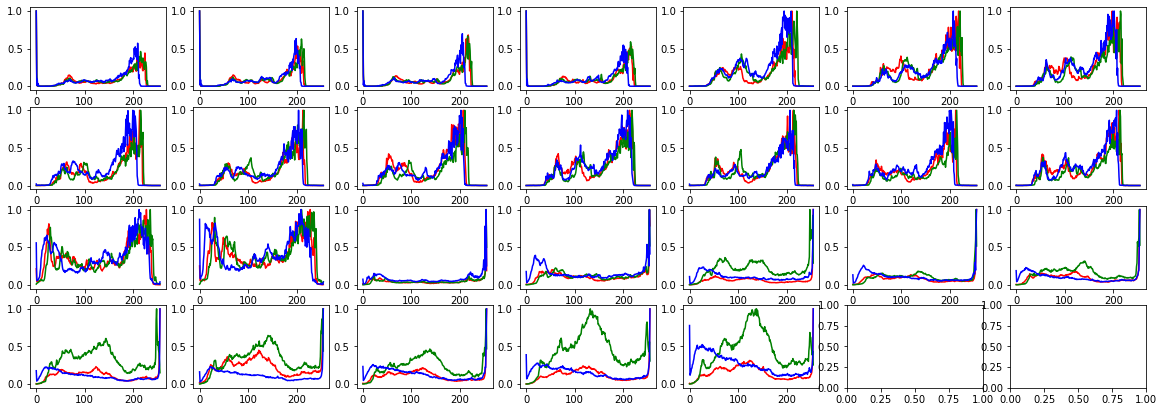

In [ ]:
plot_hist("cropped_data/Bin_2")

In [ ]:
show_images("cropped_data/Bin_2")

Output hidden; open in https://colab.research.google.com to view.

## ARUCO

In [ ]:
import cv2.aruco as aruco
actualAruco = 5*5 #cm
marker_size=9.5 #in cm
font=cv2.FONT_HERSHEY_SIMPLEX

aruco_dict=aruco.getPredefinedDictionary(aruco.DICT_6X6_1000)
aruco_params=aruco.DetectorParameters_create()

'''
camera_matrix=np.array([[528.0135498,0.,266.44139053],
                [0.,535.36743164,200.43584901],
                [0.,0.,1.]])
camera_distortion=np.array([[3.03885980e-04,5.55865722e-06,-1.79444224e-04,-2.35449758e-03,-8.71005516e-08]])
'''

def outline_aruco(im):
  corners, ids, rejected = cv2.aruco.detectMarkers(im, aruco_dict,
    parameters=aruco_params)
  
  if ids is not None:

    for corner in corners:
      # if aruco marker detected, find the coordinates of the corners
      topleft  = (int(corner[0][0][0]), int(corner[0][0][1]))
      topright = (int(corner[0][1][0]), int(corner[0][1][1]))
      botright = (int(corner[0][2][0]), int(corner[0][2][1]))
      botleft = (int(corner[0][3][0]), int(corner[0][3][1]))

      # Draw outline of aruco marker
      line_RGB = (0,0,255)
      cv2.line(im, topleft, topright, line_RGB, 2)
      cv2.line(im, topright, botright, line_RGB, 2)
      cv2.line(im, botright, botleft, line_RGB, 2)
      cv2.line(im, botleft, topleft, line_RGB, 2)
  return im

def detect_aruco(im):
  corners, ids, rejected = cv2.aruco.detectMarkers(im, aruco_dict,
    parameters=aruco_params)
  if ids:
    return True
  else:
    return False

def calculate_area(img):
  # returns total surface area as estimated from aruco size
  return

def outline_aruco_batch(input_dir, output_dir):
  os.makedirs(output_dir, exist_ok=True)
  for img_name in tqdm(sorted(os.listdir(input_dir))):
    src = os.path.join(input_dir, img_name)
    dest = os.path.join(output_dir, img_name)
    img = cv2.imread(src)

    img_aruco = outline_aruco(img)

    cv2.imwrite(dest, img_aruco)

In [ ]:
outline_aruco_batch("cropped_data/Bin_2", "aruco_outlines")

100%|██████████| 26/26 [00:00<00:00, 61.53it/s]


##Distortion

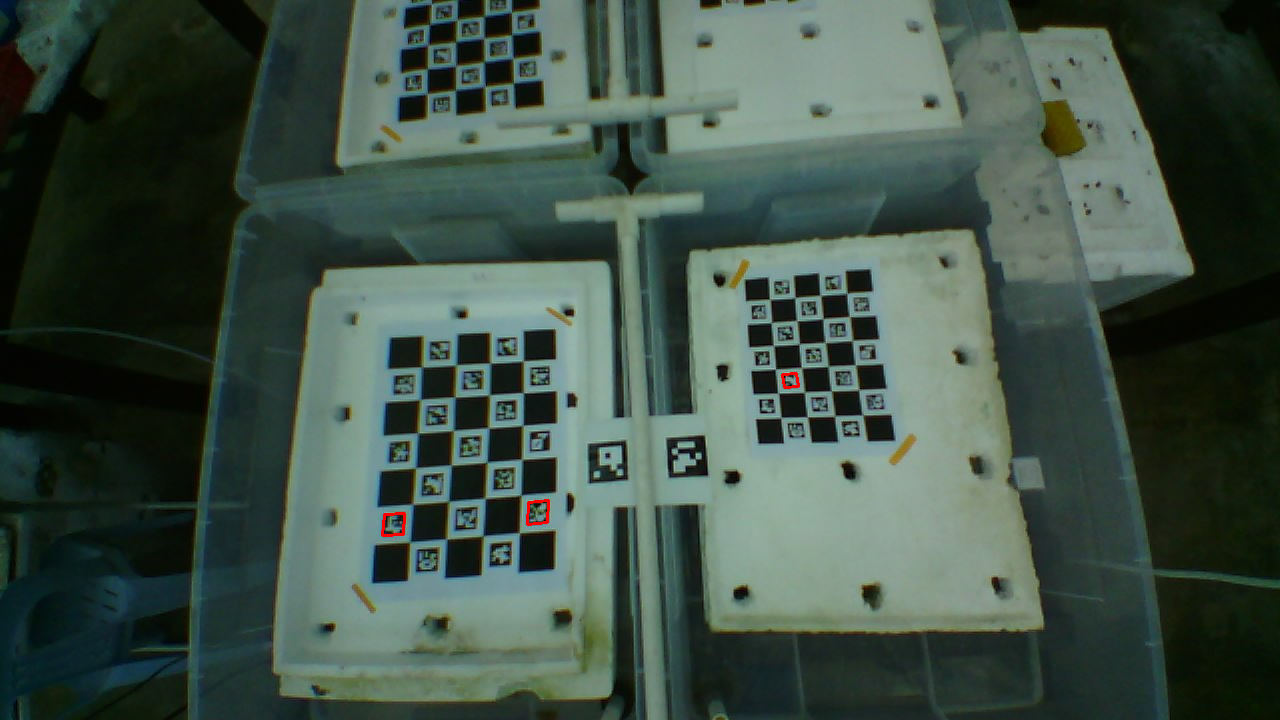

In [ ]:
aruco_dict=aruco.getPredefinedDictionary(aruco.DICT_6X6_50)
img = cv2.imread("charuco2.jpg")
cv2_imshow(outline_aruco(img))

In [ ]:
detect_aruco(img)

False

In [ ]:
def find_checkerboard(img_path, checkerboard_size = (6,4)):
  img = cv2.imread(img_path)
  img = cv2.rectangle(img, (900, 400), (771, 200), (0,0,0), -1)
  h,w = img.shape[:2]

  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
  # Creating vector to store vectors of 3D points for each checkerboard image
  objpoints = []
  # Creating vector to store vectors of 2D points for each checkerboard image
  imgpoints = [] 

  # Defining the world coordinates for 3D points
  objp = np.zeros((1, checkerboard_size[0] * checkerboard_size[1], 3), np.float32)
  objp[0,:,:2] = np.mgrid[0:checkerboard_size[0], 0:checkerboard_size[1]].T.reshape(-1, 2)
  prev_img_shape = None
  


  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  # Find the chess board corners
  # If desired number of corners are found in the image then ret = true
  ret, corners = cv2.findChessboardCorners(gray, checkerboard_size, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
    
  """
  If desired number of corner are detected,
  we refine the pixel coordinates and display 
  them on the images of checker board
  """
  if ret == True:
      objpoints.append(objp)
      # refining pixel coordinates for given 2d points.
      corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
        
      imgpoints.append(corners2)

      # Draw and display the corners
      img = cv2.drawChessboardCorners(cv2.imread(img_path), checkerboard_size, corners2, ret)

  #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

  return ret, corners, img

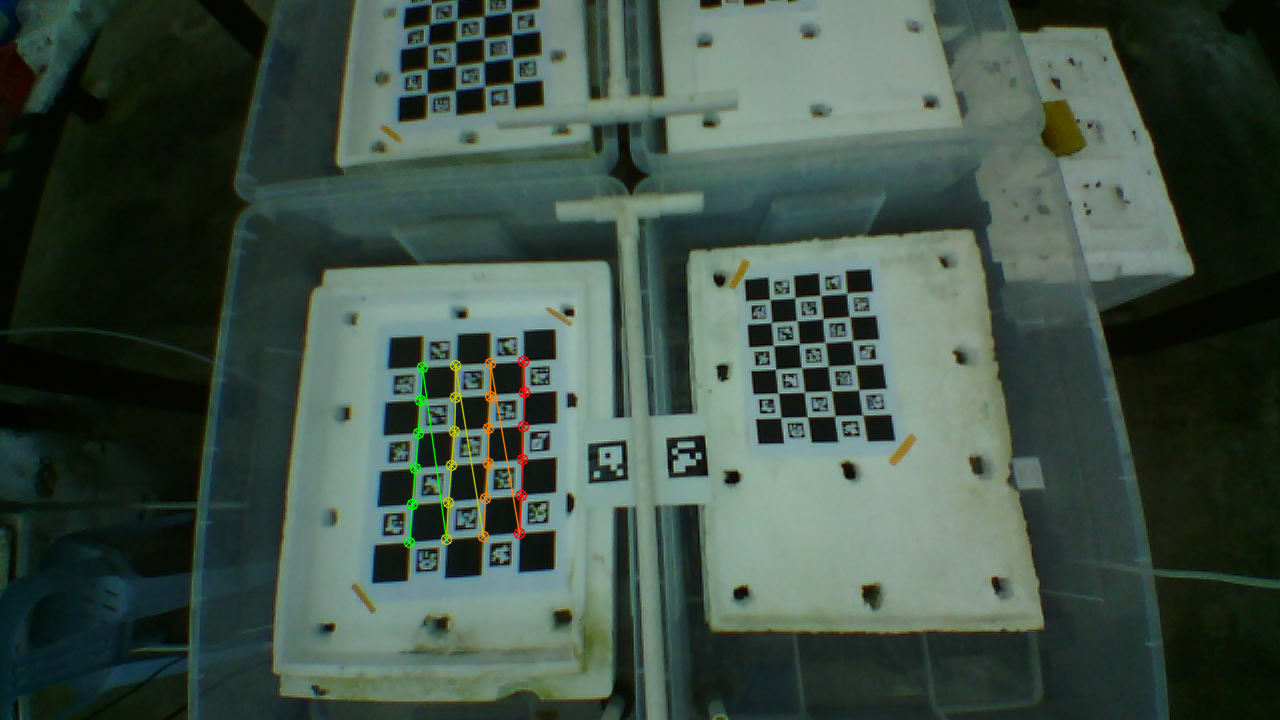

In [ ]:
ret, pts_dst, im4 = find_checkerboard("charuco2.jpg")
cv2_imshow(im4)

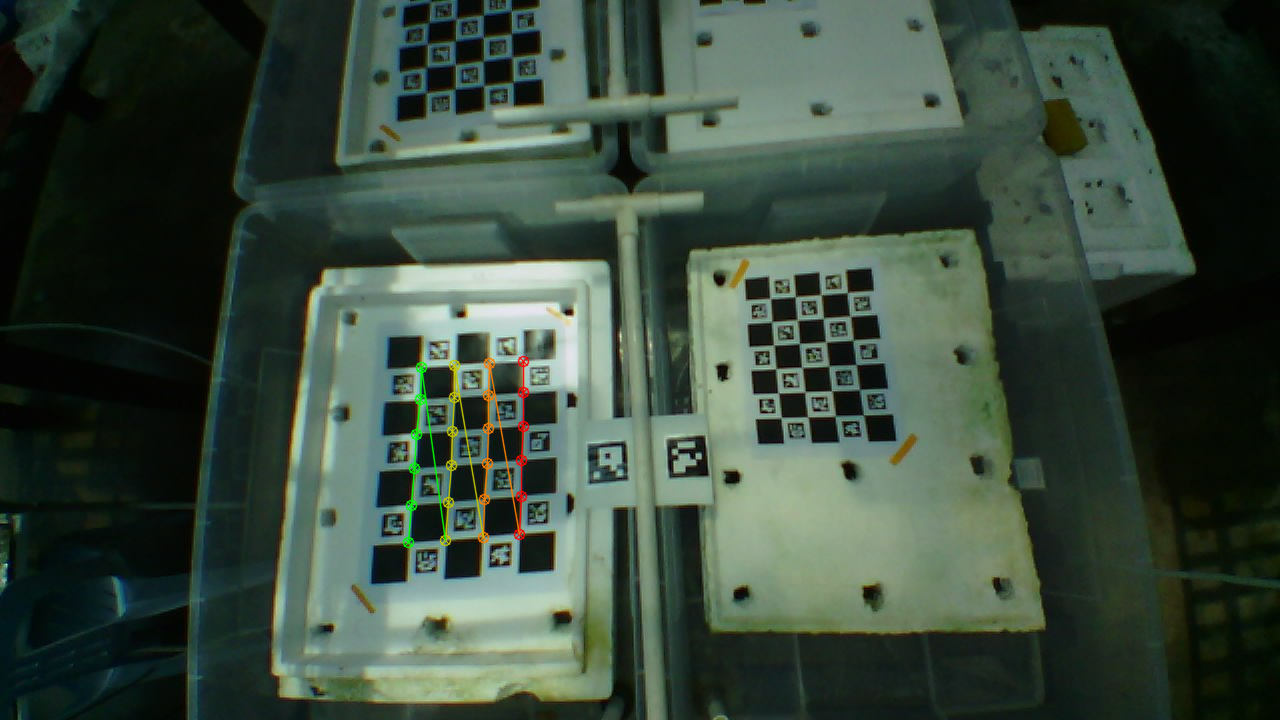

In [ ]:
ret, pts_dst, im5 = find_checkerboard("aruco5.jpg")
cv2_imshow(im5)

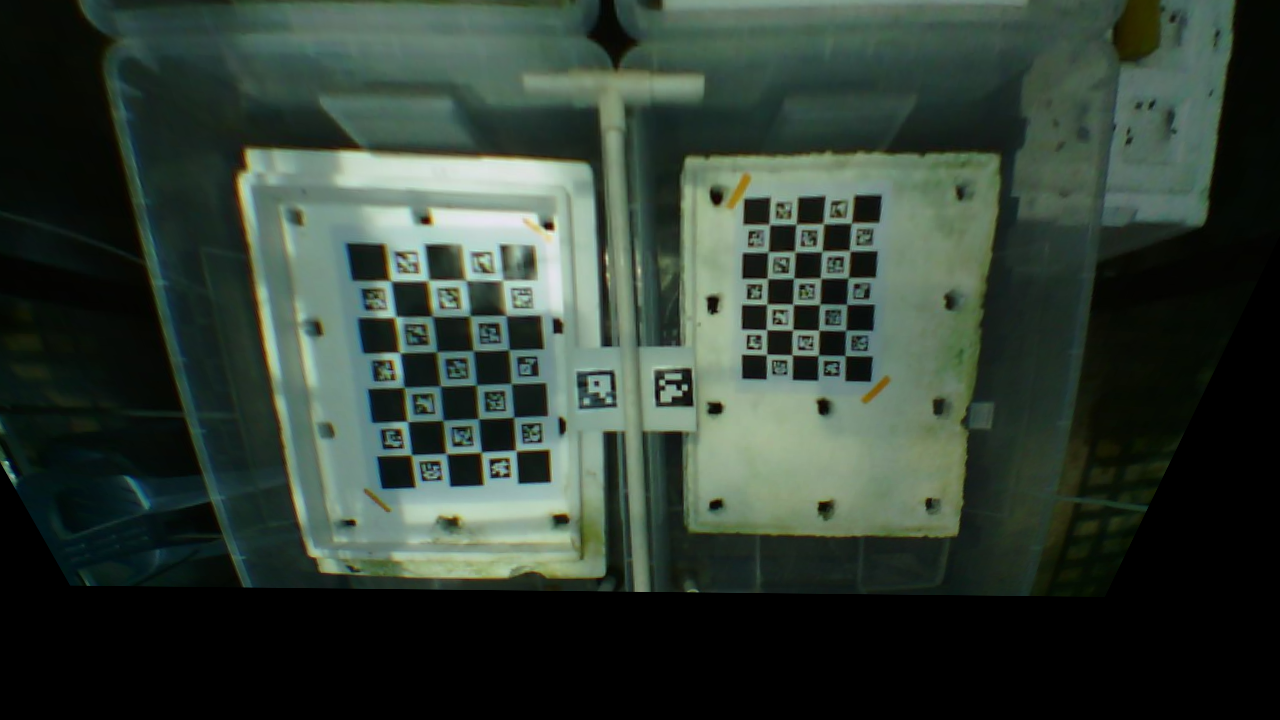

In [ ]:

h, status = cv2.findHomography(pts_src, pts_dst)
 
# Warp source image to destination based on homography
im_out = cv2.warpPerspective(cv2.imread("aruco5.jpg"), h, (aruco4.shape[1],aruco4.shape[0]))
cv2_imshow(im_out)

In [ ]:
import glob
 
# Defining the dimensions of checkerboard
CHECKERBOARD = (6,4)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = [] 
 
 
# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None
 
# Extracting path of individual image stored in a given directory
images = glob.glob('./charuco/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
     
    """
    If desired number of corner are detected,
    we refine the pixel coordinates and display 
    them on the images of checker board
    """
    if ret == True:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)
         
        imgpoints.append(corners2)
 
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
     
    cv2_imshow(img)
    cv2.waitKey(0)
 
h,w = img.shape[:2]
 
"""
Performing camera calibration by 
passing the value of known 3D points (objpoints)
and corresponding pixel coordinates of the 
detected corners (imgpoints)
"""
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
 
print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)

Output hidden; open in https://colab.research.google.com to view.

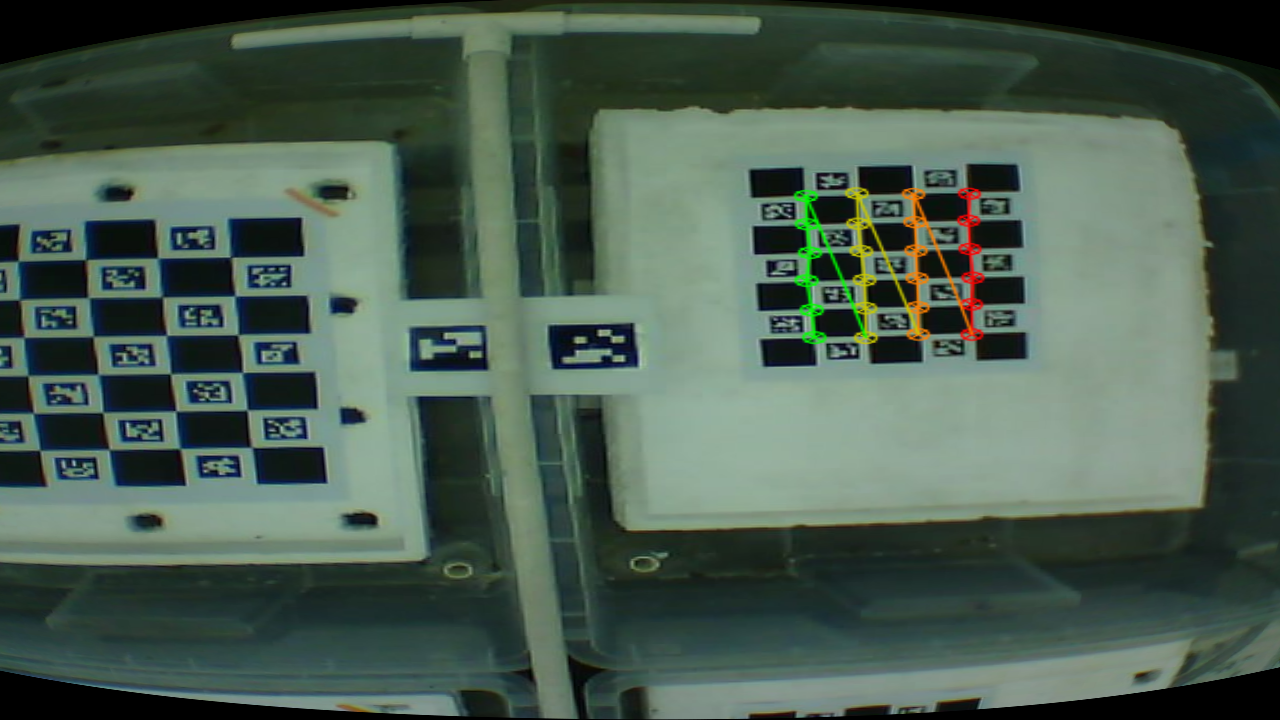

In [ ]:
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
 
# Method 1 to undistort the image
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
 
# Method 2 to undistort the image
#mapx,mapy=cv2.initUndistortRectifyMap(mtx,dist,None,newcameramtx,(w,h),5)
 
#st = cv2.remap(img,mapx,mapy,cv2.INTER_LINEAR)
cv2_imshow(dst)

## Colour correction




In [4]:
def hist_match(src, ref):
  matched = exposure.match_histograms(src, ref, multichannel=True)
  return matched

def adjust_gamma(image, gamma=1.0):

   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

def equalize_hist(img):
  img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

  # equalize the histogram of the Y channel
  img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

  # convert the YUV image back to RGB format
  img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

  return img_output

def clahe(im):
  gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  equalized = clahe.apply(gray)
  return equalized

def plot_hist(src, ref, matched):
  (fig, axs) =  plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
  # loop over our source image, reference image, and output matched
  # image
  for (i, image) in enumerate((src, ref, matched)):
    # convert the image from BGR to RGB channel ordering
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # loop over the names of the channels in RGB order
    for (j, color) in enumerate(("red", "green", "blue")):
      # compute a histogram for the current channel and plot it
      (hist, bins) = exposure.histogram(image[..., j],
        source_range="dtype")
      axs[j, i].plot(bins, hist / hist.max())
      # compute the cumulative distribution function for the
      # current channel and plot it
      (cdf, bins) = exposure.cumulative_distribution(image[..., j])
      axs[j, i].plot(bins, cdf)
      # set the y-axis label of the current plot to be the name
      # of the current color channel
      axs[j, 0].set_ylabel(color)


def get_brightness(img):
  return np.average(norm(img, axis=2)) / np.sqrt(3)

In [5]:
def hist_match_batch(dir_in, dir_out):
  os.makedirs(dir_out, exist_ok=True)
  img_list = sorted(os.listdir(dir_in))
  ref = cv2.imread(os.path.join(dir_in, img_list[0]))
  cv2.imwrite(os.path.join(dir_out, img_list[0]), ref)
  for img_name in img_list[1:]:
    src = cv2.imread(os.path.join(dir_in, img_name))
    if get_brightness(src) < 100:
      matched = hist_match(src, ref)
    else:
      ref = src
      matched = src
    cv2.imwrite(os.path.join(dir_out, img_name), matched)


In [ ]:
hist_match_batch("test_data", "hist_match_test")

In [ ]:
show_images("hist_match_test")

Output hidden; open in https://colab.research.google.com to view.

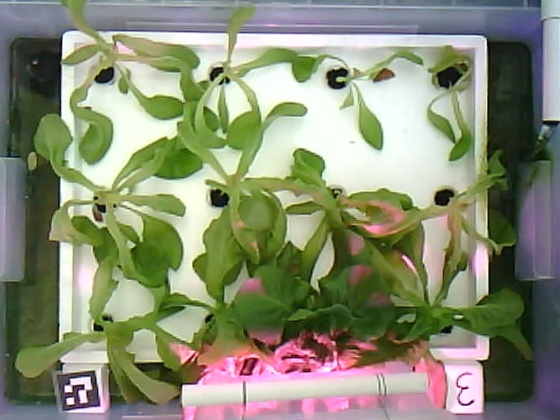

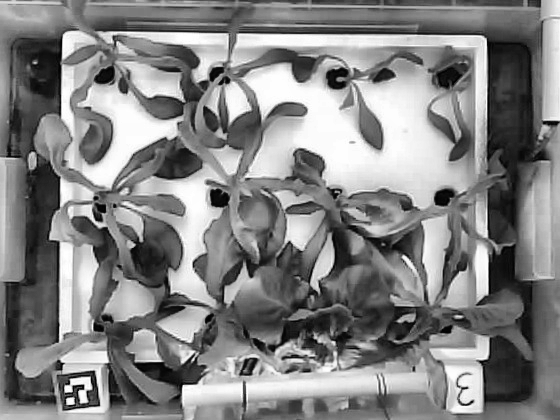

In [ ]:
light = cv2.imread("test_data/2023_01_02_1600.jpg")
cv2_imshow(light)
equal = clahe(light)
cv2_imshow(equal)

## Colour filtering

In [6]:
from PIL import Image, ImageColor

def rgb2hsv(r, g, b):
  r, g, b = (r / 255, g / 255, b / 255)

  h, s, v = colorsys.rgb_to_hsv(r, g, b)
  h, s, v = (int(h * 179), int(s * 255), int(v * 255))

  return h, s, v

def colour2binary(img):
  im_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  im_binary = cv2.threshold(im_gray, 0, 255, cv2.THRESH_BINARY)[1]
  return im_binary

def hsv_threshold(img, low_hsv=np.array([25,52,72]), high_hsv=np.array([102,255,255])):
  hsv_frame=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  mask=cv2.inRange(hsv_frame,low_hsv ,high_hsv)
  return mask

def select_colour_bgr(img, b=255, g=255, r=255, thresh=10):
  low_b, low_g, low_r = max(0,b-thresh), max(0,g-thresh), max(0,r-thresh)
  high_b, high_g, high_r = min(255,b+thresh), min(255,g+thresh), min(255,r+thresh)
  high_bgr = np.array([high_b, high_g, high_r])
  low_bgr = np.array([low_b, low_g, low_r])
  mask = cv2.inRange(img, low_bgr, high_bgr)

  # Returns binary mask
  return mask

def select_colour_hsv(img, b=255, g=255, r=255, h_range=10, sv_range=50):
  h, s, v = rgb2hsv(r, g, b)

  high_h, high_s, high_v = min(179, h + h_range), min(255, s + sv_range), min(255, v + sv_range)
  low_h, low_s, low_v = max(0, h - h_range), max(0, s - sv_range), max(0, v - sv_range)
  high_hsv = np.array([high_h, high_s, high_v])
  low_hsv = np.array([low_h, low_s, low_v])
  mask = hsv_threshold(img, low_hsv, high_hsv)

  # Returns binary mask
  return mask

def custom_threshold(img, thresh=5):
  height, width, _ = img.shape
  green = np.zeros((img.shape), np.uint8)
  for h in range(height):
    for w in range(width):
      b, g, r = img[h, w]
      b, g ,r = int(b), int(g), int(r)
      if (g-thresh > b) and (g-thresh > r) and (abs(b-r)>thresh*2):
        green[h,w] = img[h,w]

  mask = colour2binary(green)
  # Returns bgr image and binary mask
  return green, mask

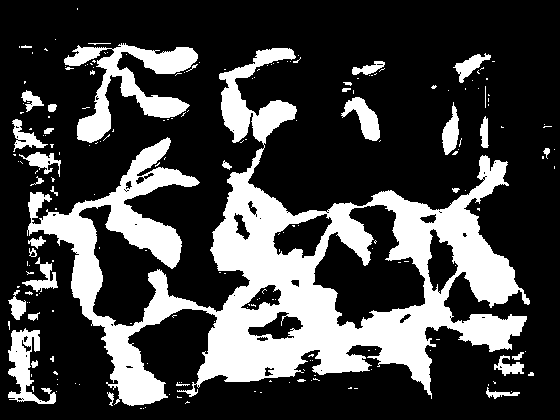

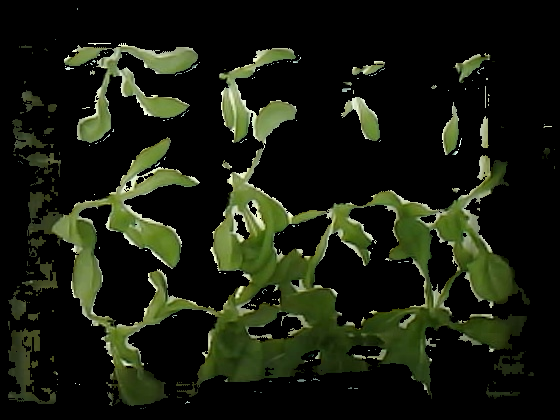

In [12]:
im = cv2.imread("cropped_data/Bin_2/2022_12_30.jpg") 
green, mask1 = custom_threshold(im)
cv2_imshow(mask1)
cv2_imshow(green)
cv2.imwrite("")

## Extract Contours

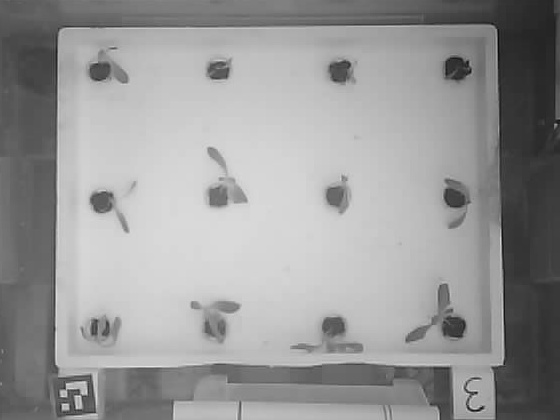

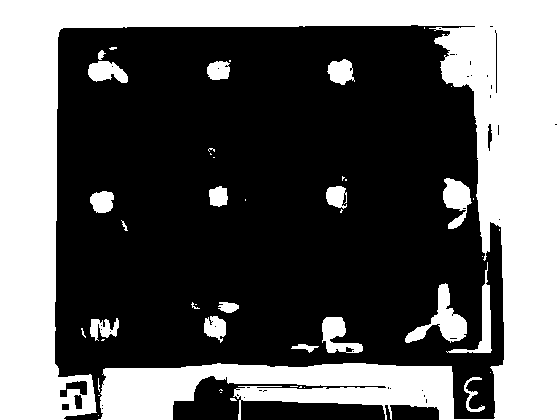

In [ ]:
img = cv2.imread("cropped_data/Bin_2/2022_12_22.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
threshold = cv2.threshold(gray, 50, 255,
cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cv2_imshow(gray)
cv2_imshow(threshold)

In [ ]:
analysis = cv2.connectedComponentsWithStats(threshold,
                                            4,
                                            cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis
  
# Initialize a new image to
# store all the output components
output = np.zeros(gray.shape, dtype="uint8")

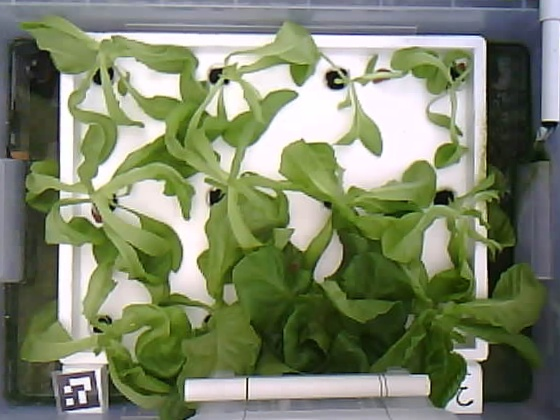

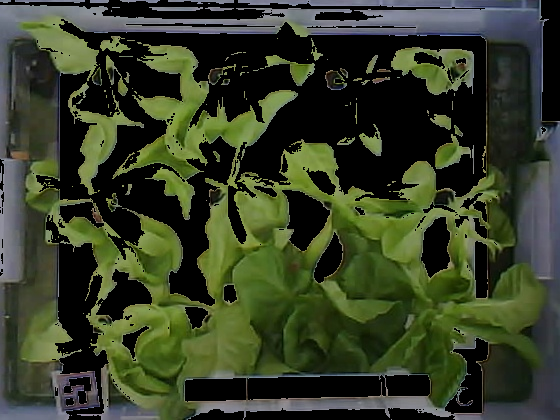

In [ ]:
cv2_imshow(img)
cv2_imshow(apply_mask(img,threshold))

## Denoise

In [ ]:
def medianblur(img):
  median = cv2.medianBlur(img,9)
  median = cv2.medianBlur(median,7)
  # returns bgr image
  return median

def remove_blobs(img, min_size=50):
  # find all of the connected components (white blobs in your image).
  # im_with_separated_blobs is an image where each detected blob has a different pixel value ranging from 1 to nb_blobs - 1.
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  nb_blobs, im_with_separated_blobs, stats, _ = cv2.connectedComponentsWithStats(gray)
  # stats (and the silenced output centroids) gives some information about the blobs. See the docs for more information. 
  # here, we're interested only in the size of the blobs, contained in the last column of stats.
  sizes = stats[:, -1]
  # the following lines result in taking out the background which is also considered a component, which I find for most applications to not be the expected output.
  # you may also keep the results as they are by commenting out the following lines. You'll have to update the ranges in the for loop below. 
  sizes = sizes[1:]
  nb_blobs -= 1


  # output image with only the kept components
  im_result = np.zeros((img.shape))
  # for every component in the image, keep it only if it's above min_size
  for blob in range(nb_blobs):
      if sizes[blob] >= min_size:
          # see description of im_with_separated_blobs above
          im_result[im_with_separated_blobs == blob + 1] = 255

  mask = colour2binary(np.uint8(im_result))
  # Returns black/white mask with 3 channels
  return mask
  
def denoise(img):
  median = medianblur(img)
  mask = remove_blobs(median)
  result = cv2.bitwise_and(img,img,mask=mask)

  return result, mask



## Preprocessing Pipeline

In [ ]:
# Utility for binary masks

def apply_mask(img, mask):
  result = cv2.bitwise_and(img, img, mask = mask)
  return result

def merge_mask(mask1, mask2):
  merge = cv2.bitwise_or(mask1,mask2)
  return merge

def subtract_mask(mask1, mask2):
  mask = cv2.bitwise_not(mask2, mask1, mask=mask2)
  return mask

def invert_mask(mask):
  inverse = cv2.bitwise_not(mask)
  return inverse

In [ ]:
def filter_1(img):
  green, _ = custom_threshold(img)
  green, _ = denoise(green)

  return green

def filter_2(img , colour):
  r, g, b = ImageColor.getrgb(colour)
  if r+g+b!=0:
    mask1 = select_colour_hsv(img, b, g, r, thresh=50)
  
  green, mask2 = custom_threshold(img)

  mask_merged = merge_mask(mask1, mask2)
  result1 = apply_mask(img, mask_merged)
  result2, _ = denoise(result1)

  return result2

def filter_3(img, colour):
  r, g, b = ImageColor.getrgb(colour)
  #if r+g+b!=0:
  mask1 = select_colour_hsv(img, b, g, r, thresh=30)
  
  green, mask2 = custom_threshold(img)

  mask_merged = subtract_mask(mask2, mask1)
  result1 = apply_mask(img, mask_merged)
  result2, _ = denoise(result1)

  return result2

def filter_4(img, whitelist, blacklist):
  _, mask = custom_threshold(img)

  for colour in blacklist:
    b, g, r = colour
    mask_blacklist = select_colour_hsv(img, b, g, r, h_range=5, sv_range=30)
    mask = subtract_mask(mask, mask_blacklist)

  for colour in whitelist:
    b, g, r = colour
    mask_blacklist = select_colour_hsv(img, b, g, r, h_range=5, sv_range=70)
    mask = merge_mask(mask, mask_blacklist)

  result = apply_mask(img, mask)
  result, _ = denoise(result)

  return result


  
def preprocess_dir(input_dir, output_dir):
  os.makedirs(output_dir, exist_ok=True)
  for img_name in tqdm(sorted(os.listdir(input_dir))):
    src = os.path.join(input_dir, img_name)
    dest = os.path.join(output_dir, img_name)

    img = cv2.imread(src)
    
    result = filter_1(img)
    cv2.imwrite(dest, result)

###Gradio

In [ ]:
def add_colour(img_rgb, colour):
  img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

  _, mask = custom_threshold(img_bgr)

  r, g, b = ImageColor.getrgb(colour)
  if r+g+b!=0:
    mask_user = select_colour_hsv(img_bgr, b, g, r)
    mask = merge_mask(mask, mask_user)
  
  print(img_bgr.shape, mask.shape)
  mask = apply_mask(img_bgr,mask)
  
  mask = medianblur(mask)
  mask = remove_blobs(mask, min_size=50)
  result_rgb = apply_mask(img_rgb,mask)

  return result_rgb                                          

demo = gr.Interface(fn=add_colour,
                    inputs = [
                        gr.Image(type="numpy"),
                        gr.ColorPicker()
                    ],
                    outputs = [
                        gr.Image()
                    ],
                    examples=[["test_data/2022_12_30_1200.jpg"],["test_data/2023_01_04_1200.jpg", "#546E2D"]],
                    live=True
                    
                    )

demo.launch(debug=False)

In [ ]:
dir = "cropped_data/Bin_2"
img_list = sorted(os.listdir(dir))[-2:]
examples = [[os.path.join(dir, img)] for img in img_list]
whitelist = []
blacklist = []

def edit_colour(img_rgb, colour_add, colour_remove):
  img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

  r, g, b = ImageColor.getrgb(colour_add)
  if r+g+b != 0:
    whitelist.append((b,g,r))

  r, g, b = ImageColor.getrgb(colour_remove)
  if r+g+b != 0:
    blacklist.append((b,g,r))

  result_bgr = filter_4(img_bgr, whitelist, blacklist)
  result_rgb = cv2.cvtColor(result_bgr, cv2.COLOR_BGR2RGB)
  return result_rgb

demo = gr.Interface(fn=edit_colour,
                    inputs = [
                        gr.Image(type="numpy"),
                        gr.ColorPicker(label="add colour"),
                        gr.ColorPicker(label="remove colour")
                    ],
                    outputs = [
                        gr.Image()
                    ],
                    examples=examples,
                    live=False
                    
                    )

demo.launch(debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
def preprocess_dir2(input_dir, output_dir, whitelist, blacklist):
  os.makedirs(output_dir, exist_ok=True)


  img_list = sorted(os.listdir(input_dir))
  img_list.reverse()
  src = os.path.join(input_dir, img_list[0])
  dest = os.path.join(output_dir, img_list[0])

  img = cv2.imread(src)
  result = filter_4(img, whitelist, blacklist)
  cv2.imwrite(dest, result)
  last_mask = colour2binary(result)
  contours, hierarchy = cv2.findContours(last_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(last_mask, contours, -1, 255, 5)

  for img_name in tqdm(img_list[1:]):
    src = os.path.join(input_dir, img_name)
    dest = os.path.join(output_dir, img_name)

    img = cv2.imread(src)
    img = apply_mask(img, last_mask)
    
    result = filter_1(img)
    last_mask = colour2binary(result)
    contours, hierarchy = cv2.findContours(last_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(last_mask, contours, -1, 255, 5)
    cv2.imwrite(dest, result)

preprocess_dir2("cropped_data/Bin_2", "test2", whitelist, blacklist)


100%|██████████| 25/25 [00:11<00:00,  2.11it/s]


In [ ]:

img = cv2.imread("cropped_data/Bin_2/2023_01_08.jpg")
result = filter_4(img, whitelist, blacklist)
last_mask = colour2binary(result)
cv2_imshow(img)
cv2_imshow(result)
cv2_imshow(last_mask)

In [ ]:
contours, hierarchy = cv2.findContours(last_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(last_mask, contours, -1, 255, 5)
cv2_imshow(last_mask)

In [ ]:
im2 = cv2.imread("cropped_data/Bin_2/2023_01_07.jpg")
t = apply_mask(im2, last_mask)
cv2_imshow(t)

In [ ]:
tm = filter_1(t)
cv2_imshow(tm)

Preprocess in backwards order: last to first

user input to obtain specific mask of last img

apply padding to mask and apply on next image before preprocessing

(able to use more lenient thresholds?)

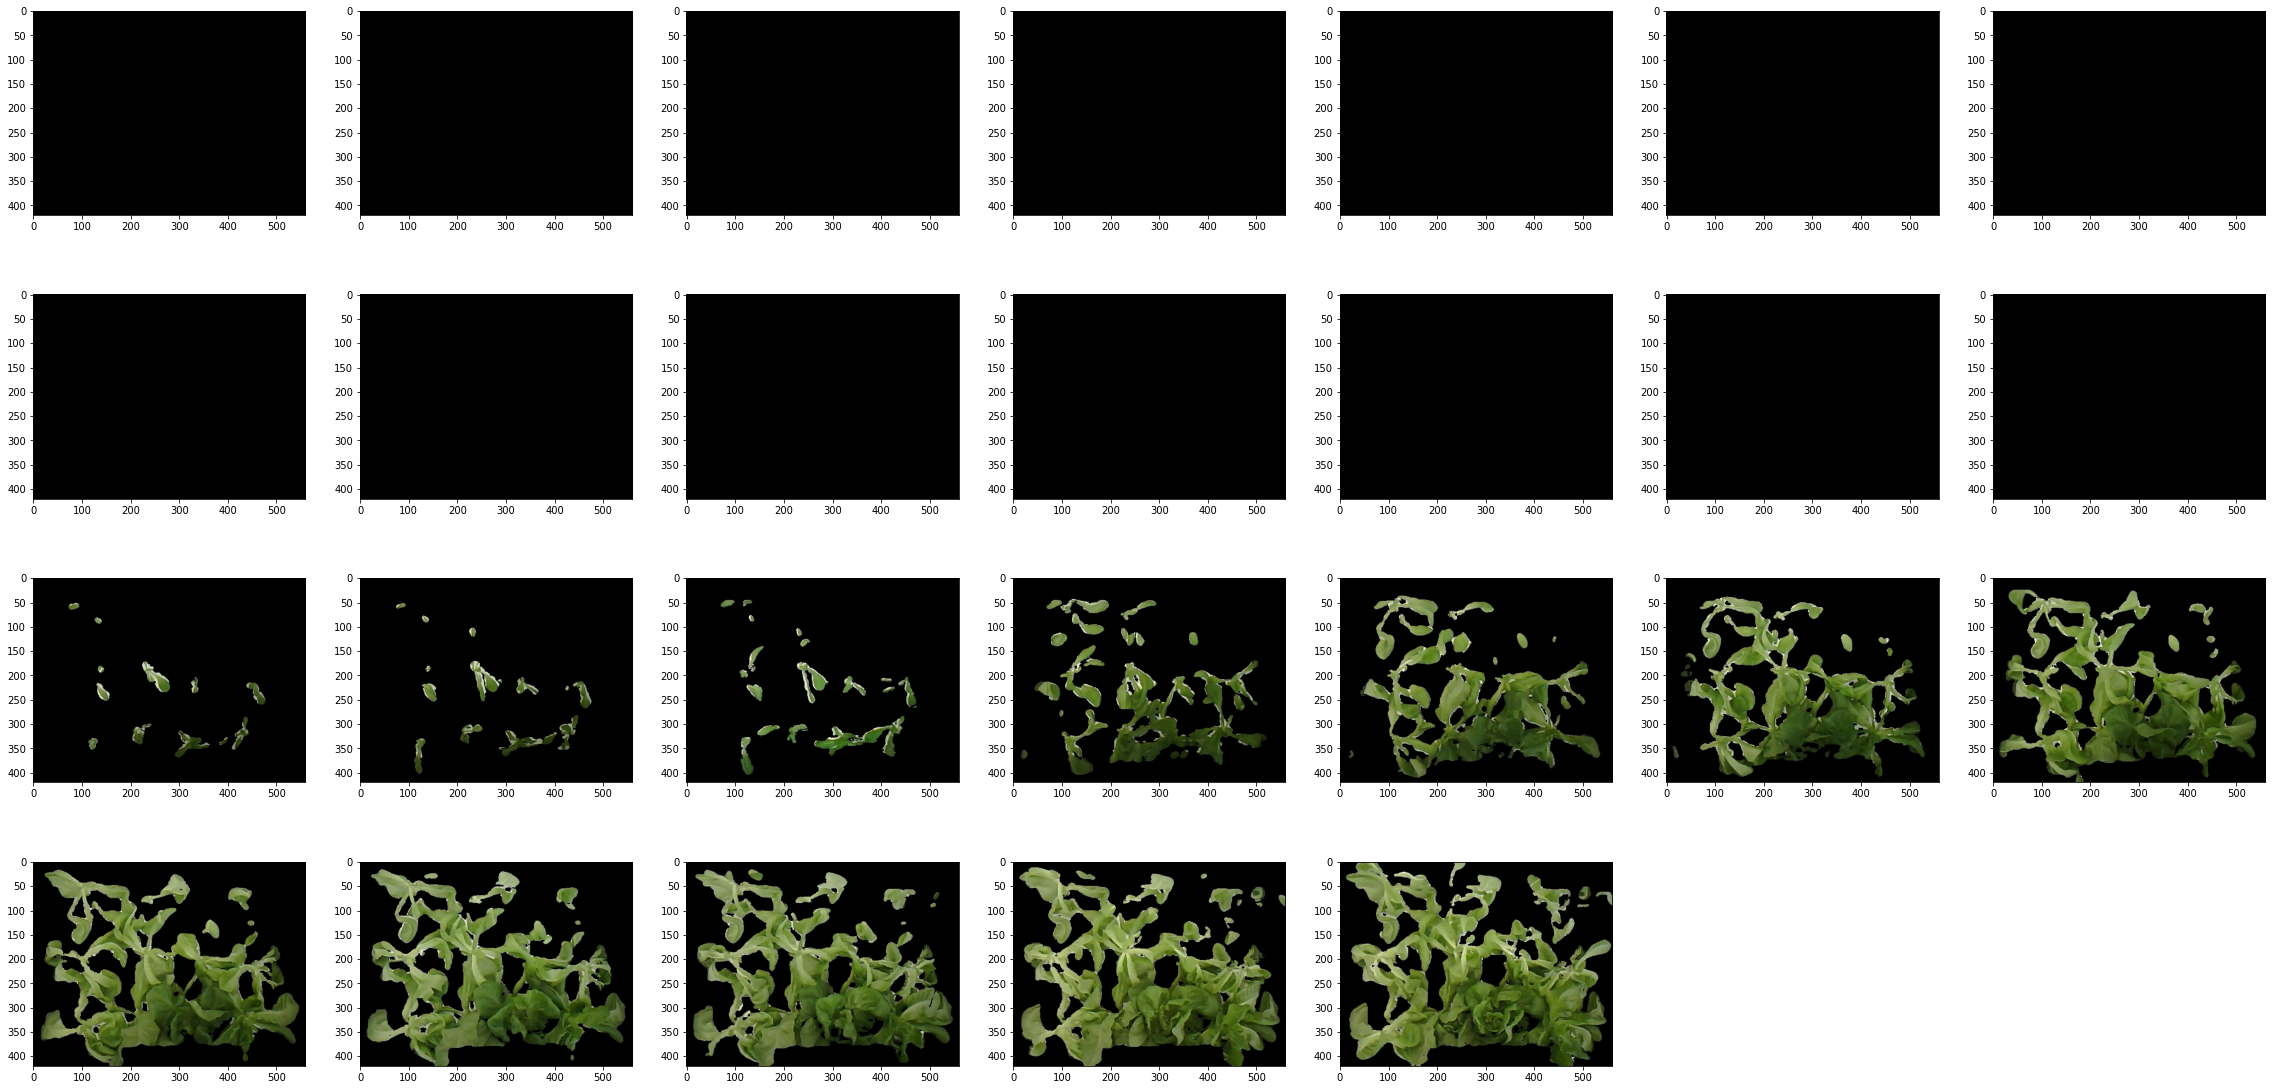

In [ ]:
show_images("test2")

100%|██████████| 26/26 [00:13<00:00,  1.99it/s]


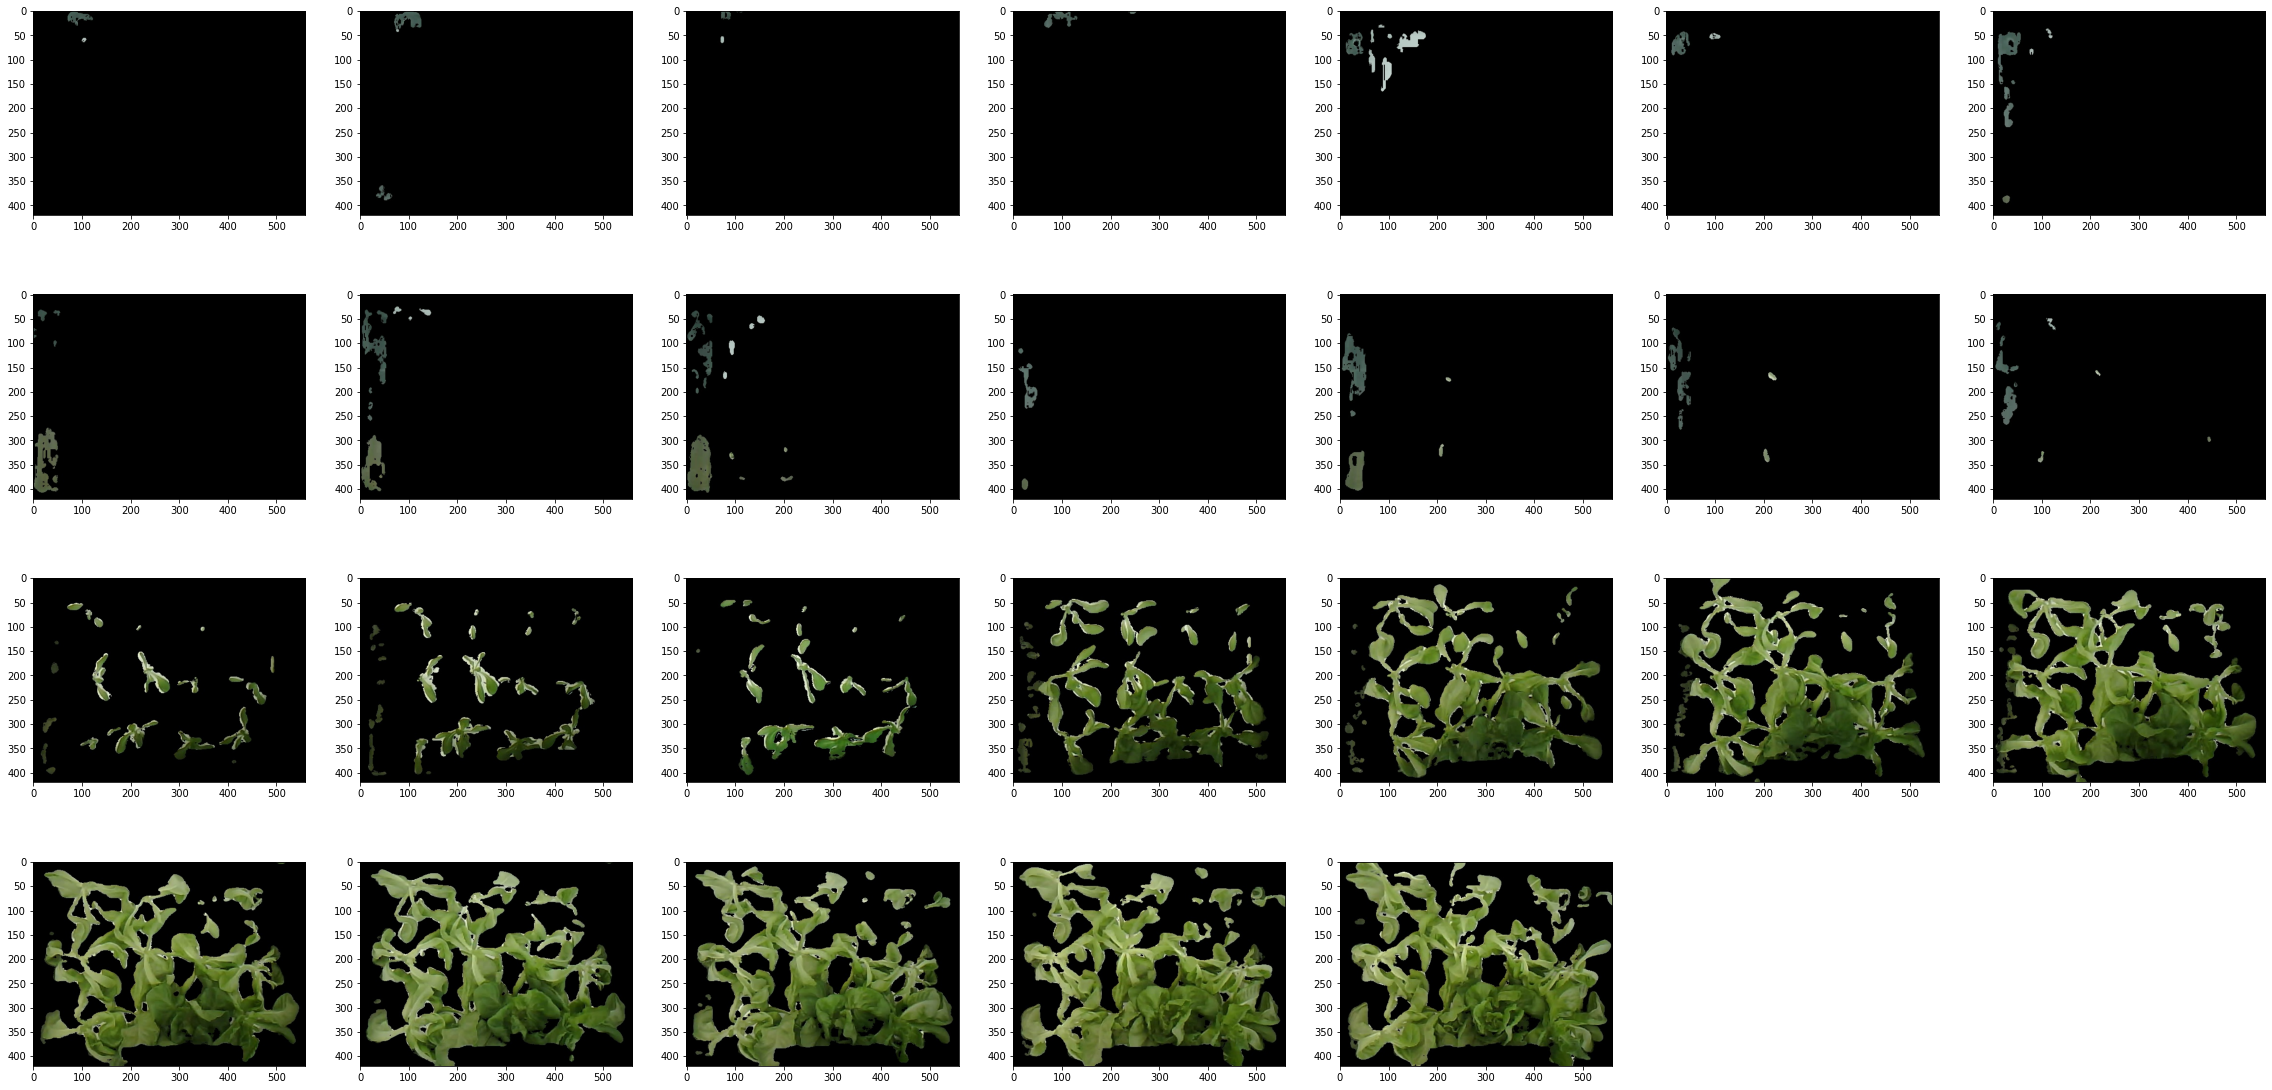

In [ ]:
preprocess_dir("cropped_data/Bin_2", "test3")
show_images("test3")

In [ ]:
show_images("cropped_data/Bin_2")

Output hidden; open in https://colab.research.google.com to view.

## Visualization (Timelapse)

In [ ]:
import imageio
def timelapse(input_dir, out_path="timelapse.mp4", img_frames = 12, fps=24):
  frames = sorted(os.listdir(input_dir))
  height, width, _ = cv2.imread(os.path.join(input_dir,frames[0])).shape
  frame_size = (width, height)
  output = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)

  for img_name in tqdm(frames):
    frame = cv2.imread(os.path.join(input_dir, img_name))
    if frame.shape[0] != height and frame.shape[1] != width:
      frame = cv2.resize(frame, frame_size)
    for _ in range(img_frames):
      
      output.write(frame)

  output.release()

def timelapse_gif(input_dir, out_path="timelapse.gif", img_frames = 6, fps=24):
  frames = sorted(os.listdir(input_dir))
  img_list = []
  for img_name in tqdm(frames):
    frame = cv2.imread(os.path.join(input_dir, img_name))
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    for _ in range(img_frames):
      img_list.append(frame)

  imageio.mimsave(out_path, img_list, fps=fps)


In [ ]:
video_path = "custom.mp4"
timelapse("filter_test/custom", video_path)
files.download(video_path)

100%|██████████| 26/26 [00:00<00:00, 80.42it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gif_path = "filter.gif"
timelapse_gif('filter_1', gif_path, img_frames=12)
files.download(gif_path)

100%|██████████| 21/21 [00:00<00:00, 141.88it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Misc

In [ ]:
!zip -r plant.zip plant
!zip -r label.zip label
from google.colab import files
files.download("plant.zip")
files.download("label.zip")

In [ ]:
split_img("plant_test.jpg", "test", (720,1080), 3, 4)

In [ ]:
def split_img(img_path, output_dir, resize_dim = (WIDTH, HEIGHT), horizontal_n = 4, vertical_n = 2):
  
  img = cv2.imread(img_path)
  img = cv2.resize(img, resize_dim)
  vars = os.path.basename(img_path).split(".")[0].split("_")
  batch_id = vars[0]
  frame_id = vars[1]

  subimg_width, subimg_height = resize_dim[0]//horizontal_n, resize_dim[1]//vertical_n
  plant_id = 1
  for i in range(vertical_n):
    y1,y2 = i*subimg_height, (i+1)*subimg_height

    for j in range(horizontal_n):
      x1,x2 = j*subimg_width, (j+1)*subimg_width
      subimg = img[y1:y2, x1:x2]


      filename = "rgb_{batch_id}_{plant_id:02d}_{frame_id}.png".format(batch_id=batch_id, plant_id=plant_id,frame_id=frame_id)
      outpath = os.path.join(output_dir, filename)
      cv2.imwrite(outpath, subimg)
      plant_id += 1

def split_imgs_in_dir(input_dir, output_dir, resize_dim = (WIDTH, HEIGHT), horizontal_n = 4, vertical_n = 3):
  for img_name in os.listdir(input_dir):
    if img_name.endswith(".png") or img_name.endswith(".jpg"):
      img_path = os.path.join(input_dir, img_name)
      split_img(img_path, output_dir)

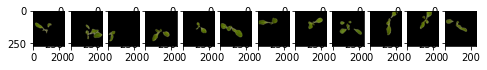

In [ ]:
preprocess_dir("test", "label")
show_images("label")

Cropping and rotation

In [ ]:
im = cv2.imread("cropped_data/Bin_2/2022_12_09.jpg")
im.shape

(420, 560, 3)

In [ ]:
for img_name in sorted(os.listdir("cropped_data/Bin_2")):

  img = cv2.imread("cropped_data/Bin_2/{}".format(img_name))
  WIDTH, HEIGHT, _ = img.shape
  #img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
  #img = img[150:600]

  #img = cv2.resize(img, (WIDTH, HEIGHT))

  hsv_frame=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  low_green=np.array([0,50,50])
  high_green=np.array([80,255,255])
  green_mask=cv2.inRange(hsv_frame,low_green,high_green)
  green=cv2.bitwise_and(img,img,mask=green_mask)  
  #cv2_imshow(green)

  black = np.sum(green==0)
  total = WIDTH*HEIGHT*3
  print("{}: {}".format(img_name, 1 - black/total))

2022_12_09.jpg: 0.013133503401360547
2022_12_10.jpg: 0.010510204081632613
2022_12_11.jpg: 0.02687074829931968
2022_12_12.jpg: 0.01605867346938772
2022_12_13.jpg: 0.007963435374149674
2022_12_14.jpg: 0.0054039115646258296
2022_12_15.jpg: 0.010858843537414953
2022_12_16.jpg: 0.07354591836734692
2022_12_17.jpg: 0.062448979591836706
2022_12_18.jpg: 0.07613520408163266
2022_12_19.jpg: 0.008358843537415006
2022_12_20.jpg: 0.04092261904761907
2022_12_21.jpg: 0.021062925170068025
2022_12_22.jpg: 0.020654761904761898
2022_12_25.jpg: 0.132046485260771
2022_12_26.jpg: 0.16870039682539684
2022_12_27.jpg: 0.11675453514739231
2022_12_30.jpg: 0.29461876417233557
2023_01_01.jpg: 0.4011309523809524
2023_01_02.jpg: 0.40966978458049885
2023_01_03.jpg: 0.4534367913832199
2023_01_04.jpg: 0.4645082199546485
2023_01_05.jpg: 0.47668792517006797
2023_01_06.jpg: 0.4944968820861678
2023_01_07.jpg: 0.5469968820861678
2023_01_08.jpg: 0.5643452380952381
